In [65]:
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cycler import cycler
from scipy import signal
import pandas as pd
import sys
from os.path import dirname
sys.path.append("/Users/mprange/PycharmProjects/flight_phase_seperation/")

import FlightPhaseTools as fpt
from typhon.files import FileSet
from typhon.plots import styles, worldmap
plt.style.use(styles.get('typhon'))
import yaml

In [4]:
bahamas_fs = FileSet(path='unified/bahamas_{year}{month}{day}_v0.4.nc')
dropsondes_fs = FileSet(path='unified/dropsondes_{year}{month}{day}_v0.4.nc')

In [5]:
bahamas_all = bahamas_fs.collect()
dropsondes_all = dropsondes_fs.collect()

In [9]:
bahamas = bahamas_all[3]
dropsondes = dropsondes_all[3]

In [13]:
takeoff_ts = np.array(0)
enter_c1_ts = fpt.ds_timestamp(bahamas, dropsondes, 0)
exit_c1_ts = fpt.ds_timestamp(bahamas, dropsondes, 11)
enter_c2_ts = fpt.ds_timestamp(bahamas, dropsondes, 12)
exit_c2_ts = fpt.ds_timestamp(bahamas, dropsondes, 23)
enter_c3_ts = fpt.ds_timestamp(bahamas, dropsondes, 24)
exit_c3_ts = fpt.ds_timestamp(bahamas, dropsondes, 34)
max_roll_b4_leg1_ts = fpt.max_timestamp(bahamas, 'roll', 
          slice('2020-01-28T18:30:00', '2020-01-28T19:00:00'),
          order=500
                                   )
enter_leg1_ts = fpt.find_first_value_after_ts(bahamas, 'roll', max_roll_b4_leg1_ts, 0., 0.05)
max_roll_after_leg1_ts = fpt.max_timestamp(bahamas, 'roll', 
          slice('2020-01-28T19:00:00', '2020-01-28T19:20:00'),
          order=500
         )
exit_leg1_ts = fpt.find_first_value_before_ts(bahamas, 'roll', max_roll_after_leg1_ts, 0., 0.05)
min_roll_b4_rad_cal_ts = fpt.min_timestamp(bahamas, 'roll', 
          slice('2020-01-28T19:00:00', '2020-01-28T19:20:00'),
          order=500
         )
enter_rad_cal_ts = fpt.find_first_value_after_ts(bahamas, 'heading', min_roll_b4_rad_cal_ts, 0., 1.0)
max_roll_after_rad_cal_ts = fpt.max_timestamp(bahamas, 'roll', 
          slice('2020-01-28T19:15:00', '2020-01-28T19:30:00'),
          order=500
         )
exit_rad_cal_ts = fpt.find_first_value_before_ts(bahamas, 'roll', max_roll_after_rad_cal_ts, -10., 0.1)
max_roll_b4_leg2_ts = fpt.max_timestamp(bahamas, 'roll', 
          slice('2020-01-28T19:10:00', '2020-01-28T19:30:00'),
          order=1000
                                   )
enter_leg2_ts = fpt.find_first_value_after_ts(bahamas, 'roll', max_roll_b4_leg2_ts, 0., 0.05)
max_roll_after_leg2_ts = fpt.max_timestamp(bahamas, 'roll', 
                                       slice('2020-01-28T19:30:00', '2020-01-28T20:00:00'),
                                       order=1000
                                      )
exit_leg2_ts = fpt.find_first_value_before_ts(bahamas, 'roll', max_roll_after_leg2_ts, 0., 0.05)
enter_c4_ts = fpt.ds_timestamp(bahamas, dropsondes, 35)
exit_c4_ts = fpt.ds_timestamp(bahamas, dropsondes, 45)
enter_c5_ts = fpt.ds_timestamp(bahamas, dropsondes, 46)
exit_c5_ts = fpt.ds_timestamp(bahamas, dropsondes, 57)
enter_c6_ts = fpt.ds_timestamp(bahamas, dropsondes, 58)
exit_c6_ts = fpt.ds_timestamp(bahamas, dropsondes, 69)
touchdown_ts = np.array(len(bahamas['time'])-2)

ts_list = [takeoff_ts, touchdown_ts, enter_c1_ts, exit_c1_ts, enter_c2_ts, 
           exit_c2_ts, enter_c3_ts, exit_c3_ts, enter_leg1_ts, 
           exit_leg1_ts, enter_rad_cal_ts, exit_rad_cal_ts, 
           enter_leg2_ts, exit_leg2_ts, enter_c4_ts, exit_c4_ts, 
           enter_c5_ts, exit_c5_ts, enter_c6_ts, exit_c6_ts]
label_list = ["takeoff", "touchdown", "enter_c1", "exit_c1", 
              "enter_c2", "exit_c2", "enter_c3", "exit_c3", 
              "enter_leg1", "exit_leg1", "enter_rad_cal", 
              "exit_rad_cal", "enter_leg2", "exit_leg2", 
              "enter_c4", "exit_c4", "enter_c5", "exit_c5", 
              "enter_c6", "exit_c6"]

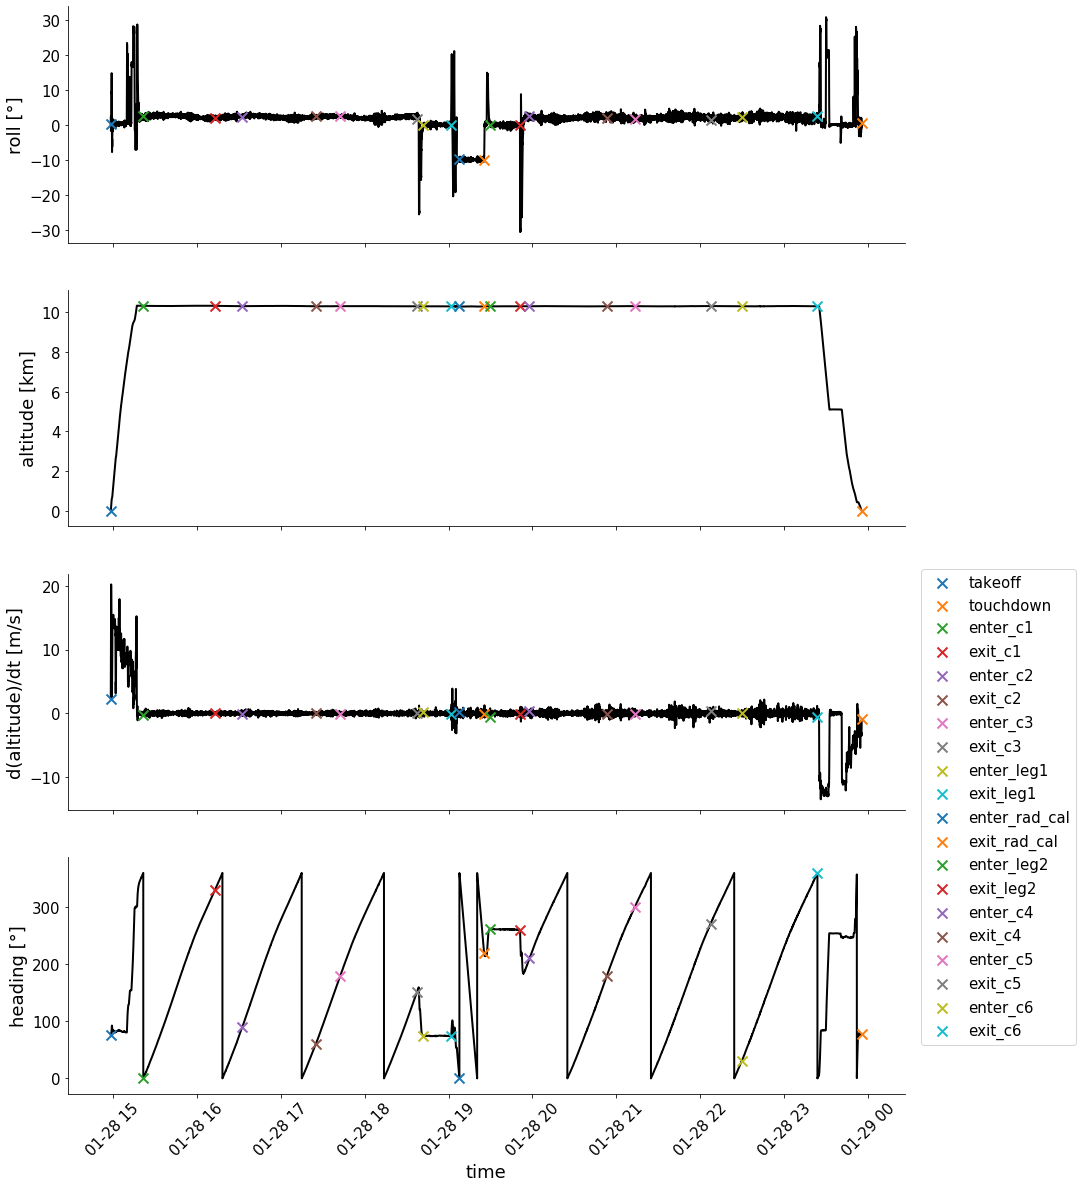

In [14]:
fpt.plot_timeseries(bahamas, dropsondes, ts_list, label_list)

In [9]:
ts_list_int = np.array([int(entry) for entry in ts_list])
time_stamps = bahamas['time'][ts_list_int].values
time_stamp_labels = np.array(['liftoff_touchdown', 'c1', 'c2', 'c3', 
                              'leg1', 'radar_calibration', 'leg2', 'c4', 'c5', 'c6'])
flight_phase_timestamps = xr.Dataset(
    coords={
        'flight_phase': (['flight_phase'], time_stamp_labels),
    },
    {
        'time': (['flight_phase'], time_stamps)
    },
    attrs={
        'mission': bahamas.attrs['mission'],
        'flight_number': bahamas.attrs['flight_number'],
        'flight_date': str(pd.to_datetime(bahamas['time'][0].values).date()), 
        'contact': 'marc.prange@uni-hamburg.de',
    }
)

In [56]:
ts_list_int = np.array([int(entry) for entry in ts_list])
time_stamps = bahamas['time'][ts_list_int].values
time_stamps = time_stamps.reshape((int(len(time_stamps) / 2), 2))
time_stamp_labels = np.array(['liftoff_touchdown', 'c1', 'c2', 'c3', 
                              'leg1', 'radar_calibration', 'leg2', 'c4', 'c5', 'c6'])
flight_phase_ds = xr.Dataset(
    coords=
    {
        'flight_phase': (time_stamp_labels),
        'start_end': np.array(['phase_start', 'phase_end'])
    },
    data_vars=
    {
        'timestamp': (('flight_phase', 'start_end'), time_stamps),
    },
    attrs=
    {
        'mission': bahamas.attrs['mission'],
        'flight_number': bahamas.attrs['flight_number'],
        'flight_date': str(pd.to_datetime(bahamas['time'][0].values).date()), 
        'contact': 'marc.prange@uni-hamburg.de',
    }
)

In [69]:
print(yaml.dump(
    {
        'flight_phase': time_stamp_labels,
        'start_end': np.array(['phase_start', 'phase_end']),
        'timestamp': time_stamps,
    }
))

flight_phase: !!python/object/apply:numpy.core.multiarray._reconstruct
  args:
  - &id001 !!python/name:numpy.ndarray ''
  - !!python/tuple
    - 0
  - !!binary |
    Yg==
  state: !!python/tuple
  - 1
  - !!python/tuple
    - 10
  - !!python/object/apply:numpy.dtype
    args:
    - U17
    - 0
    - 1
    state: !!python/tuple
    - 3
    - <
    - null
    - null
    - null
    - 68
    - 4
    - 8
  - false
  - !!binary |
    bAAAAGkAAABmAAAAdAAAAG8AAABmAAAAZgAAAF8AAAB0AAAAbwAAAHUAAABjAAAAaAAAAGQAAABv
    AAAAdwAAAG4AAABjAAAAMQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
    AAAAAAAAAAAAAAAAAAAAAAAAAAAAAGMAAAAyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
    AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYwAAADMAAAAAAAAAAAAAAAAAAAAAAAAA
    AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABsAAAAZQAAAGcAAAAx
    AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHIA
    AABhAAAAZAAAAGEAAAByAAAAXwAAAGMAAABhAAAAbAAAAGkAAABiAAAAcgAAAGEAAAB0AAAAaQAA
    

In [63]:
flight_phase_ds.to_netcdf(
    f'flight_phase_timestamps/RF_{flight_phase_ds.flight_number}_' \
    f'{flight_phase_ds.flight_date}_flight_phase_timestamps_v2.nc')

In [12]:
timestamps = xr.open_dataset('flight_phase_timestamps/RF_05_2020-01-28_flight_phase_timestamps.nc')
timestamps['flight_phase']

<xarray.DataArray 'flight_phase' (time: 20)>
array(['takeoff', 'enter_c1', 'exit_c1', 'enter_c2', 'exit_c2', 'enter_c3',
       'exit_c3', 'enter_leg1', 'exit_leg1', 'enter_rad_cal', 'exit_rad_cal',
       'enter_leg2', 'exit_leg2', 'enter_c4', 'exit_c4', 'enter_c5', 'exit_c5',
       'enter_c6', 'exit_c6', 'touchdown'], dtype=object)
Coordinates:
    time_stamps  (time) datetime64[ns] ...
Dimensions without coordinates: time

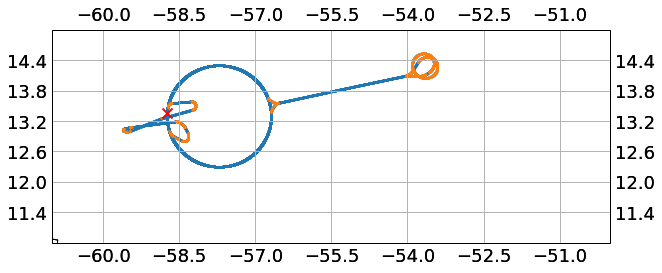

In [114]:
ax = plt.axes(projection=ccrs.PlateCarree())
worldmap(bahamas[3]["lat"],
         bahamas[3]["lon"],
         draw_grid=True, draw_coastlines=True, ax=ax)
worldmap(bahamas[3]["lat"][high_roll],
         bahamas[3]["lon"][high_roll],
         draw_grid=True, draw_coastlines=True, ax=ax)
worldmap(bahamas[3]["lat"][ds1],
         bahamas[3]["lon"][ds1],
         marker="x", color='red', s=100)
ax.set_extent([-61, -50, 10.8, 15], crs=ccrs.PlateCarree())

In [101]:
## Main idea: Seperate each flight into phases, e.g. ascent, circle numbers, transitions between circles, 
# transitions between circle and excursion.
# How to store the data? Create seperate meta data files that contain the transition time stamps. 
# There should be clear name tags associated with each flight phase.

"""
Ideas for name tags:
- takeoff
- enter_circle1
- exit_circle1
- enter_circle2
- exit_circle2
- enter_circle3
- exit_circle3
- enter_leg1
- exit_leg1
- enter_leg2
- exit_leg2
- enter_circle4
- exit_circle4
- enter_circle5
- exit_circle5
- enter_circle6
- exit_circle6
- landing
"""